# Проверка гипотезы наличия связи между интеграциями с блогерами и органическими заказами

Отдел маркетинга периодически проводит рекламные интеграции с блогерами.
Блогеры рекламируют платформу Flowwow и делятся со своими подписчиками персональным промокодом на скидку.

Если оценивать интеграции только по количеству заказов с промокодов, то с точки зрения стоимости привлечения трафика, такая реклама выглядит убыточно. 
В то же время появилось предположение, что интеграции могут влиять на прирост заказов по органическому трафику.


Задание:
1. Доказать или опровергнуть наличие влияния интеграций на прирост органических заказов

2.  Если влияние такое есть, то рассчитать дополнительную ценность (количество дополнительных заказов из органики, которые можно атрибутировать блогерам).

3. Визуализировать полученные результаты в виде презентации


In [34]:
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_ad7ed2c951b546c98e77f18b29d8a869 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='7ql-6UHsrzYQxywNIWAZ0TYhmH_f6O2qJxBKIV6beKqI',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_ad7ed2c951b546c98e77f18b29d8a869.get_object(Bucket='flowwow-donotdelete-pr-qtpa80m0o58mtf',Key='Dataset_for_analyst - Dataset.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_1 = pd.read_csv(body)
df_1.head()


,date,all inf orders,organic orders
0,2020.02.01,0,195
1,2020.02.02,0,173
2,2020.02.03,0,268
3,2020.02.04,0,287
4,2020.02.05,0,251


Подготовка данных.

In [35]:
df_1=df_1.rename(columns={"all inf orders": "inf_ord", "organic orders": "org_ord"})

In [36]:
df_1.dtypes

date       object
inf_ord     int64
org_ord     int64
dtype: object

In [37]:
from datetime import datetime

In [38]:
df_1['date'] =  pd.to_datetime(df_1['date'],format='%Y.%m.%d')

In [39]:
df_1.dtypes

date       datetime64[ns]
inf_ord             int64
org_ord             int64
dtype: object

In [40]:
df_1.set_index('date', inplace=True)
print(df_1.head(5))

            inf_ord  org_ord
date                        
2020-02-01        0      195
2020-02-02        0      173
2020-02-03        0      268
2020-02-04        0      287
2020-02-05        0      251


In [41]:
df_1.tail()

,inf_ord,org_ord
date,,
2021-01-29,0,0
2021-01-30,0,0
2021-01-31,0,0
2021-02-01,0,0
2021-02-02,0,0


In [42]:
df_2 = df_1.drop(df_1[df_1.org_ord <= 1].index)

In [43]:
df_2.tail()

,inf_ord,org_ord
date,,
2021-01-07,2,235
2021-01-08,2,202
2021-01-09,3,218
2021-01-10,5,245
2021-01-11,1,325


Визуализация временных рядов.

In [44]:
from matplotlib import pyplot

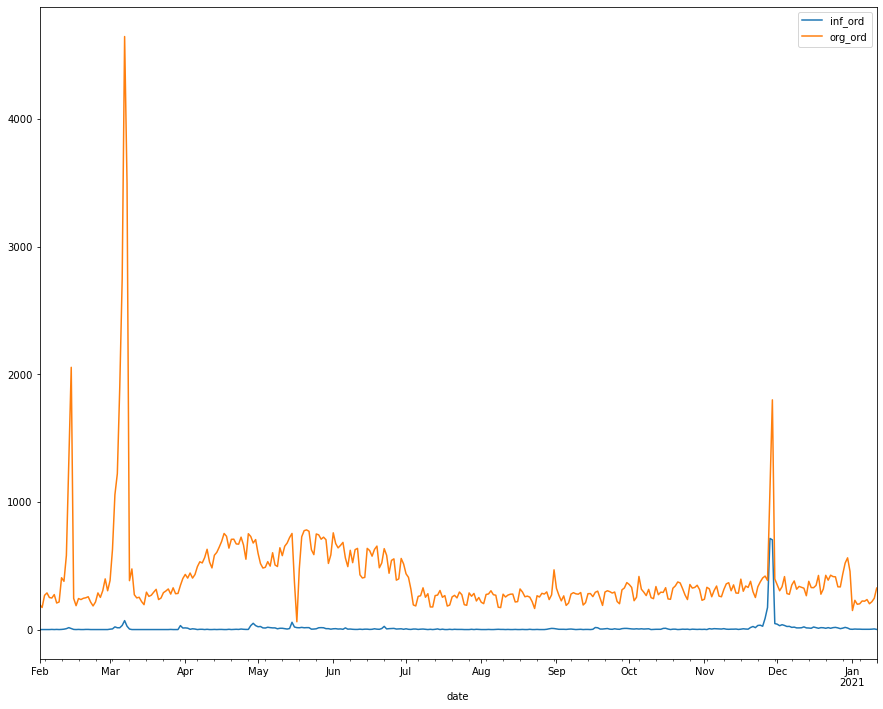

In [45]:
df_2.plot(figsize=(15,12))

Исходя из анализа графика не представляется возможным точно доказать или опровергнуть гипотезу о наличии связи. С одной стороны, видны несколько периодов одномоментного изменения двух показателей, с другой стороны, во-первых, таких периодов не много, во-вторых, видно, что лишь малая часть вариации показателя органических заказов может быть объяснена вариацией показателя информационных заказов при интеграции с блогерами. 

Следовательно, анализа графической информации, представленной выше, пока недостаточно для какого-либо утверждения относительно гипотезы исследования. Требуется применение: а) более детальных графических инструментов; б)статистических методов анализа.

Для большей наглядности посмотрим на два временных ряда по отдельности.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa6c350b090>,
      dtype=object)

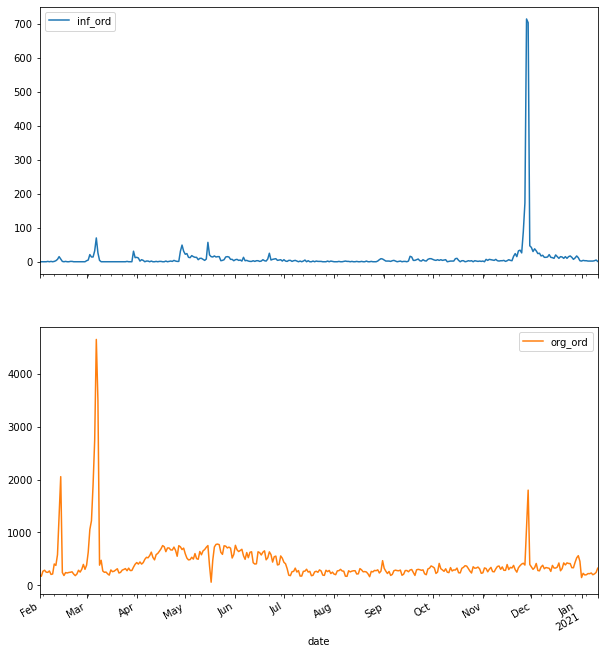

In [46]:
df_2.plot(subplots=True, figsize=(10,12))

Заметим, что средние значения волатильности у данных показателей разные. Покупки через инфопартнеров имеют диапазон 0-100 с одним экстремальным промежутком около 700 заказов, в то же время, у покакателя органических покупок - в среднем от 0 до 100, с экстремальными значениями около нескольких тысяч.

Следовательно, для большей сопоставимости можно трансформировать данные временные ряды. Методов трансформации много. Для начала проверим данные на Нормальное распределение. Будем использовать тест Колмогорова-Смирнова.

In [47]:
from scipy.stats import kstest, norm
ks_statistic, p_value = kstest(df_2['inf_ord'], 'norm')
print(ks_statistic, p_value)

0.621758538572052 1.4280982941079563e-129


In [48]:
from scipy.stats import kstest, norm
ks_statistic, p_value = kstest(df_2['org_ord'], 'norm')
print(ks_statistic, p_value)

1.0 0.0


Временные ряды не имеют нормальное распределение, таким образом, для сопоставимости двух показателей можно использовать Normalization (Min-Max Scaling).

In [49]:
from sklearn.preprocessing import MinMaxScaler

In [50]:
scaler = MinMaxScaler()

In [51]:
df_3=df_2

In [52]:
df_3[['inf_ord', 'org_ord']] = scaler.fit_transform(df_3[['inf_ord', 'org_ord']])

In [53]:
df_3

,inf_ord,org_ord
date,,
2020-02-01,0.000000,0.029219
2020-02-02,0.000000,0.024422
2020-02-03,0.000000,0.045137
2020-02-04,0.000000,0.049280
2020-02-05,0.000000,0.041430
...,...,...
2021-01-07,0.002801,0.037942
2021-01-08,0.002801,0.030746
2021-01-09,0.004202,0.034235


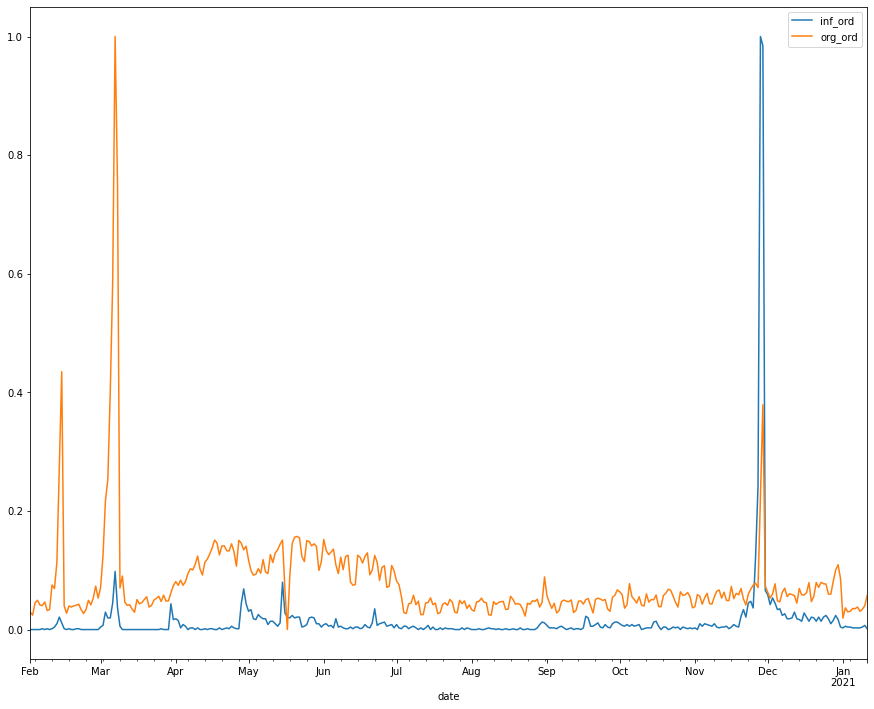

In [54]:
df_3.plot(figsize=(15,12))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa6c32b1d10>,
      dtype=object)

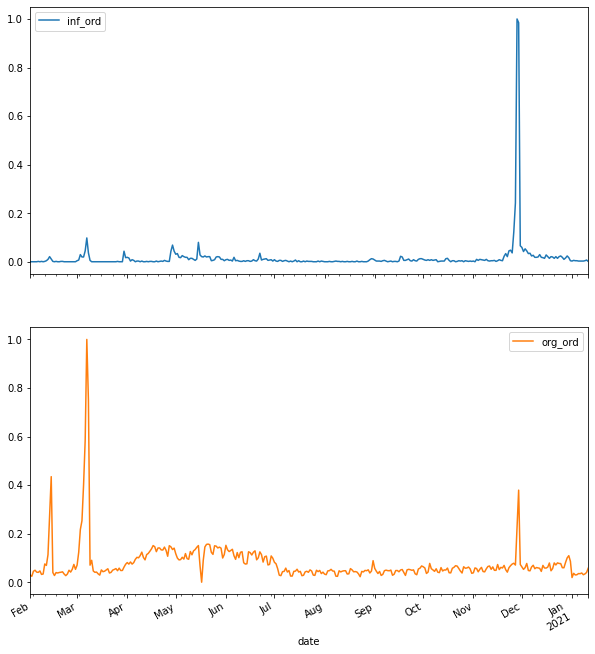

In [55]:
df_3.plot(subplots=True, figsize=(10,12))

После выполнения данной трансформации все равно явной причинности не наблюдается. Так или иначе, графический анализ является всего лишь наглядным инструментом и не строгим. Далее проверим гипотезу о причинности с помощью статистических методов.

Сначала необходимо проверить два временных ряда на коинтеграцию, чтобы понять, насколько

Одним из популярных тестов для проверки причинности во временных рядах является тест причинности Гренджера.

In [56]:
columns_titles = ["org_ord","inf_ord"]
df_3=df_3.reindex(columns=columns_titles)

In [57]:
from statsmodels.tsa.stattools import grangercausalitytests

In [58]:
gc_results=grangercausalitytests(df_3,30)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0203  , p=0.8869  , df_denom=342, df_num=1
ssr based chi2 test:   chi2=0.0205  , p=0.8863  , df=1
likelihood ratio test: chi2=0.0205  , p=0.8863  , df=1
parameter F test:         F=0.0203  , p=0.8869  , df_denom=342, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.8026  , p=0.0621  , df_denom=339, df_num=2
ssr based chi2 test:   chi2=5.6879  , p=0.0582  , df=2
likelihood ratio test: chi2=5.6414  , p=0.0596  , df=2
parameter F test:         F=2.8026  , p=0.0621  , df_denom=339, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.4804  , p=0.0610  , df_denom=336, df_num=3
ssr based chi2 test:   chi2=7.5963  , p=0.0551  , df=3
likelihood ratio test: chi2=7.5134  , p=0.0572  , df=3
parameter F test:         F=2.4804  , p=0.0610  , df_denom=336, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.3351  , p=0.0554  

Тест Грэнджера показал, что временной ряд покупок при интеграции с инфопартнерами может быть причиной временного ряда обычных покупок. Проверялась гипотеза на 30 лагах (месяц). Значимые лаги оказались значимы на 5% уровне - с пятого до десятый. На 10% уровне значимости -со второго по тринадцатый. Это может говорить о том, что взаимодействие с инфопартенрами и дальнейшие покупки с привлечением инфопартнеров могут оказывать причинность на покупки с обычного трафика во временной перспективе от нескольких дней до недели - максимум две недели. То есть наибольший эффект в масштабе первой недели. Далее эффект причинности затухает.

Создадим авторегрессионную модель с распределенными лагами, чтобы оценить количественное влияние заказов с инфопартнерством на обычные заказы в динамике.

In [59]:
def lag(x, n):
    if n == 0:
        return x
    if isinstance(x, pd.Series):
        return x.shift(n) 
    else:
        x = pd.Series(x)
        return x.shift(n) 

    x = x.copy()
    x[n:] = x[0:-n]
    x[:n] = np.nan
    return x

In [60]:
import statsmodels.formula.api as smf

In [61]:
mod_L5_10_est = smf.ols(formula = 'org_ord ~ 1 + lag(inf_ord, 5) + lag(inf_ord, 6) + lag(inf_ord, 7) + lag(inf_ord, 8) + lag(inf_ord, 9)+ lag(inf_ord, 10)', data = df_2)
mod_L5_10_fit = mod_L5_10_est.fit()
print(mod_L5_10_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                org_ord   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.017
Method:                 Least Squares   F-statistic:                   0.08043
Date:                Fri, 15 Jan 2021   Prob (F-statistic):              0.998
Time:                        18:53:40   Log-Likelihood:                 352.81
No. Observations:                 336   AIC:                            -691.6
Df Residuals:                     329   BIC:                            -664.9
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.0809      0.005  

Коэффициенты при лагах 5-10 оказались незначимы в авторегресионной модели с распределенными лагами.

Также для анализа причинной зависимости используется модель векторной авторегрессии. Использование данной модели может быть оправданно в данном случае, так как заказы с инфопартнерств могут иметь влияние на обычные заказы, и наоборот. Например, после того, как покупатель совершил целевое действие на маркетплейсе он может найти информацию о блогере, который рекламирует данную площадку и совершает или повторный заказ, или советует этот маркетплейс знакомым или друзьям.

Проверка на стационарность.

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from scipy import stats
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse, aic
import pickle

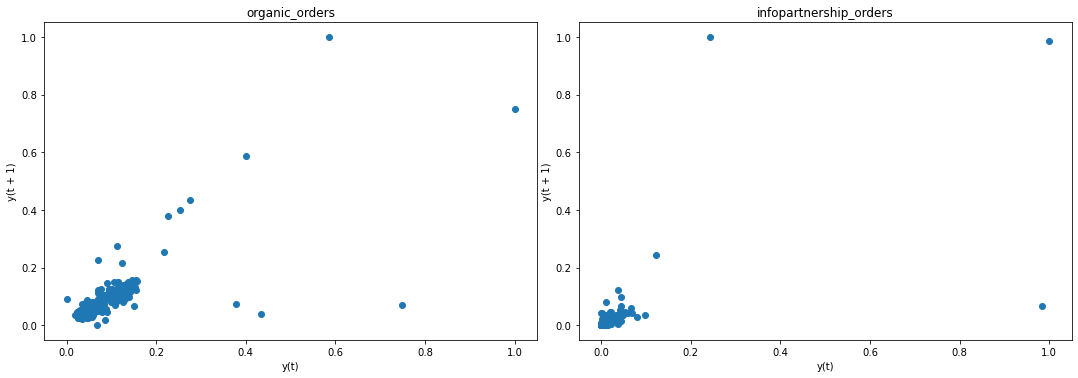

In [66]:
from pandas.plotting import lag_plot
   
f1, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
f1.tight_layout()

lag_plot(df_3['org_ord'], ax=ax1)
ax1.set_title('organic_orders');

lag_plot(df_3['inf_ord'], ax=ax2)
ax2.set_title('infopartnership_orders');


plt.show()


Как видно из графиков, скорее всего, имеется стационарность в двух временных рядах. То есть в каждом показателе имеется как минимум что-либо из следующего: тренд, сезонность, цикличность.

Проведем два теста на стационарность. ADF и KPSS.

In [67]:
df_4 = df_3.copy(deep=True)

In [68]:
df_3['org_ord'] = df_3['org_ord'] - df_3['org_ord'].shift(1)
df_3['inf_ord'] = df_3['inf_ord'] - df_3['inf_ord'].shift(1)
df_3 = df_3.dropna()

In [69]:
msk = np.random.rand(len(df_3)) < 0.8
train = df_3[msk]
test = df_3[~msk]

In [70]:
from statsmodels.tsa.stattools import adfuller

X1 = np.array(df_3['org_ord'])
X1 = X1[~np.isnan(X1)]

result = adfuller(X1)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    
    
X2 = np.array(df_3['inf_ord'])
X2 = X2[~np.isnan(X2)]

result = adfuller(X2)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -10.596871
p-value: 0.000000
Critical Values:
	1%: -3.450
	5%: -2.870
	10%: -2.571
ADF Statistic: -9.030335
p-value: 0.000000
Critical Values:
	1%: -3.450
	5%: -2.870
	10%: -2.571


In [71]:
from statsmodels.tsa.stattools import kpss
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

kpss_test(X1)
kpss_test(X2)

KPSS Statistic: 0.03338416772848898
p-value: 0.1
num lags: 17
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary
KPSS Statistic: 0.027176579159812947
p-value: 0.1
num lags: 17
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1661: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


Тесты показали, что теперь ряды стационарные. Представим это графически.

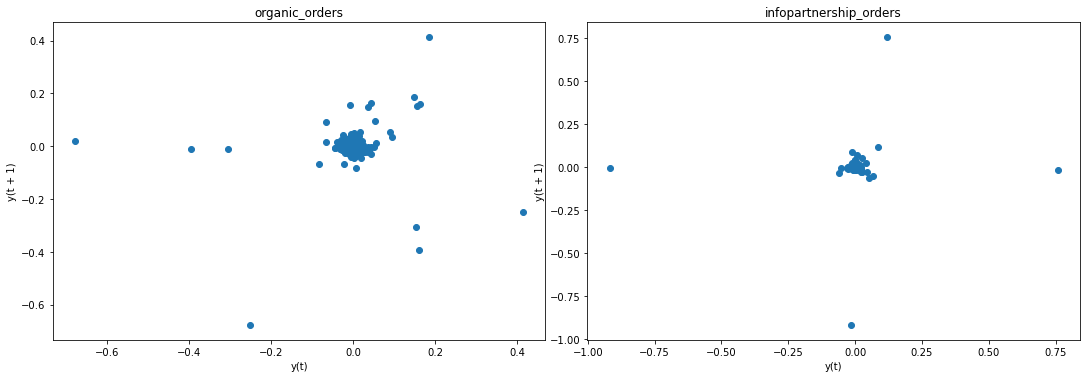

In [72]:
from pandas.plotting import lag_plot
   
f1, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
f1.tight_layout()

lag_plot(df_3['org_ord'], ax=ax1)
ax1.set_title('organic_orders');

lag_plot(df_3['inf_ord'], ax=ax2)
ax2.set_title('infopartnership_orders');


plt.show()


Определим параметр глубины запаздывания p для VAR модели.

In [80]:
df_4 = df_4.dropna()
model = VAR(df_4)
for i in range(1,31):
    result = model.fit(i)
    try:
        print('Lag Order =', i)
        print('AIC : ', result.aic)
        print('BIC : ', result.bic)
        print('FPE : ', result.fpe)
        print('HQIC: ', result.hqic, '\n')
    except:
        continue

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Lag Order = 1
AIC :  -11.541280022549048
BIC :  -11.474435771818067
FPE :  9.720445124673652e-06
HQIC:  -11.514659586602516 

Lag Order = 2
AIC :  -11.697419373810236
BIC :  -11.585772814002869
FPE :  8.315284097383145e-06
HQIC:  -11.652951893365906 

Lag Order = 3
AIC :  -11.75618320227206
BIC :  -11.599541143204062
FPE :  7.840782920393514e-06
HQIC:  -11.693787928864191 

Lag Order = 4
AIC :  -11.754797505973896
BIC :  -11.552965361917968
FPE :  7.851757256441904e-06
HQIC:  -11.674393102878646 

Lag Order = 5
AIC :  -11.755866868678819
BIC :  -11.508648644337947
FPE :  7.84352596345489e-06
HQIC:  -11.65737140504709 

Lag Order = 6
AIC :  -11.74552018887103
BIC :  -11.452718465171426
FPE :  7.925337968287604e-06
HQIC:  -11.628851133787254 

Lag Order = 7
AIC :  -11.731155658699135
BIC :  -11.39257157839998
FPE :  8.040333347840306e-06
HQIC:  -11.59622987516489 

Lag Order = 8
AIC :  -11.712528104248214
BIC :  -11.327961357365307
FPE :  8.191953192332241e-06
HQIC:  -11.559261843089507 

In [81]:
model = VAR(train)
model_fitted = model.fit(2)

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [82]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(df_3.columns, out):
    print(col, ':', round(val, 2))

org_ord : 1.95
inf_ord : 2.0


Серийной корреляции в остатках нет.

In [84]:
import statsmodels.tsa.stattools as ts 
result=ts.coint(df_3['org_ord'], df_3['inf_ord'])
print(result)

(-10.595119724078192, 8.114397130952106e-18, array([-3.92856024, -3.35394958, -3.05680206]))


В рядах наблюдается коинтеграция.

In [86]:
model = VAR(train)
model_fitted = model.fit(2)
lag_order = 10


/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [88]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=lag_order
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

table = grangers_causation_matrix(train, variables = train.columns) 

In [89]:
table

,org_ord_x,inf_ord_x
org_ord_y,1.0000,0.0
inf_ord_y,0.0017,1.0


Модель VAR показала, что причинности или нет, или она слабая, насмотря на то, что ряды коинтегрированы.

# Вывод

Таким образом, графический анализ показал, что причинности скорее всего нет. Далее тест Гренджэра показал статистическую значимость на 5% уровне для 5-10 лагов запаздывания, хотя на 1% уровне значимости никакой из лагов не значим. Более или менее, можно утверждать, что может быть какая-либо слабая причинность по Грэнджеру в масштабе примерно недельного лага запаздывания. Модели ADL и VAR также показали, что определить значимость не удалось для указанных лагов. Причем после очистки временных рядов от сезонности, трендов и циклтичности, то есть после приведения к рядов стационарному виду - недельные лаги оказались незначимы.

Какие шаги необходимо предпринять, чтобы еще раз протестировать значимость? Во-первых, провести детальный маркетинговый анализ предметной области: какая может быть причинность? Однонаправленная, двунаправленная? Во-вторых, использовать методы контролируемых экспериментов. В-третьих, использование более широкой выборки.

Как может быть рассчитана дополнительная ценность, если бы была найдена причинность? Для каждого года имеем y(t) и имеем значения лагов x(t), x(t-1), x(t-2), x(t-p) и значимые коэффициенты alpha1, alpha 2, alpha p при этих лагах. Умножили бы каждый x на альфу и просуммировали (внутри этого года t). Далее вычли бы из y(t). Это будет дополнительная ценность в году t. И далее суммировать по всем t принадлежащим T, где T - все временные промежутки с первого по последний день. Так мы бы смогли получить кумулятивную дополнительную ценность.

Информация для дальнейшей работы или окончательный вывод: не найдена сильная статистическая причинность между заказами с участием инфомартнеров и обычных заказов, скорее всего, не стоит надеяться на эту возможную связь для увеличения органических покупок.